In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(8)

import numpy as np
import matplotlib.pyplot as plt

import candel

from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_median
import jax
from corner import corner


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data = candel.pvdata.load_SH0ES_separated("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")
q_names = data["q_names"]
data.keys()
# q_

2025-06-09 13:10:54 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-09 13:10:54 indices of zero width: [44]
2025-06-09 13:10:54 found zero-width prior at index 44. Setting it to 0.


dict_keys(['OH', 'logP', 'mag_cepheid', 'C_Cepheid', 'L_Cepheid', 'L_Cepheid_host_dist', 'L_SN_Cepheid_dist', 'L_SN_dist', 'C_SN_Cephed', 'Y_SN_Cepheid', 'L_SN_Cepheid', 'mu_N4258_anchor', 'e_mu_N4258_anchor', 'mu_LMC_anchor', 'e_mu_LMC_anchor', 'Y_SN', 'C_SN', 'L_SN', 'M_HST', 'e_M_HST', 'M_Gaia', 'e_M_Gaia', 'sigma_grnd', 'q_names', 'num_hosts', 'num_cepheids', 'num_flow_SN', 'czcmb_cepheid_host', 'e_czcmb_cepheid_host', 'RA_host', 'dec_host'])

In [3]:
# m = data["czcmb_cepheid_host"] > 3300

# data["e_czcmb_cepheid_host"][m] = 3000

In [4]:
model = candel.model.SH0ESModel(data)
kernel = NUTS(model, init_strategy=init_to_median(num_samples=5000))

mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=8)
mcmc.run(jax.random.PRNGKey(4), use_uniform_mu_priors=False)
mcmc.print_summary()


samples = mcmc.get_samples()

2025-06-09 13:10:58 Converting host RA/dec to Cartesian coordinates.
2025-06-09 13:10:58 set the following attributes: OH, logP, mag_cepheid, C_Cepheid, L_Cepheid, L_Cepheid_host_dist, L_SN_Cepheid_dist, L_SN_dist, C_SN_Cephed, Y_SN_Cepheid, L_SN_Cepheid, mu_N4258_anchor, e_mu_N4258_anchor, e2_mu_N4258_anchor, mu_LMC_anchor, e_mu_LMC_anchor, e2_mu_LMC_anchor, Y_SN, C_SN, L_SN, M_HST, e_M_HST, e2_M_HST, M_Gaia, e_M_Gaia, e2_M_Gaia, sigma_grnd, num_hosts, num_cepheids, num_flow_SN, czcmb_cepheid_host, e_czcmb_cepheid_host, e2_czcmb_cepheid_host, RA_host, dec_host, rhat_host


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]


                               mean       std    median      5.0%     95.0%     n_eff     r_hat
                       H0     67.51      1.63     67.49     64.78     70.13   3926.06      1.00
                      M_W     -5.92      0.02     -5.92     -5.96     -5.89   3038.86      1.00
                 Vext_mag    342.82     88.73    344.26    198.77    490.48   4993.13      1.00
                      Z_W     -0.19      0.05     -0.19     -0.29     -0.10   7889.54      1.00
                      b_W     -3.29      0.01     -3.29     -3.31     -3.26   7629.88      1.00
                      dZP     -0.01      0.04     -0.01     -0.07      0.05   4249.22      1.00
                   mu_LMC     18.48      0.03     18.48     18.44     18.52   8773.00      1.00
                   mu_M31     24.40      0.07     24.40     24.29     24.51   8649.46      1.00
                 mu_N4258     29.41      0.02     29.41     29.37     29.44   4711.43      1.00
               mu_host[0]     29.22    

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_74677/3429464527.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


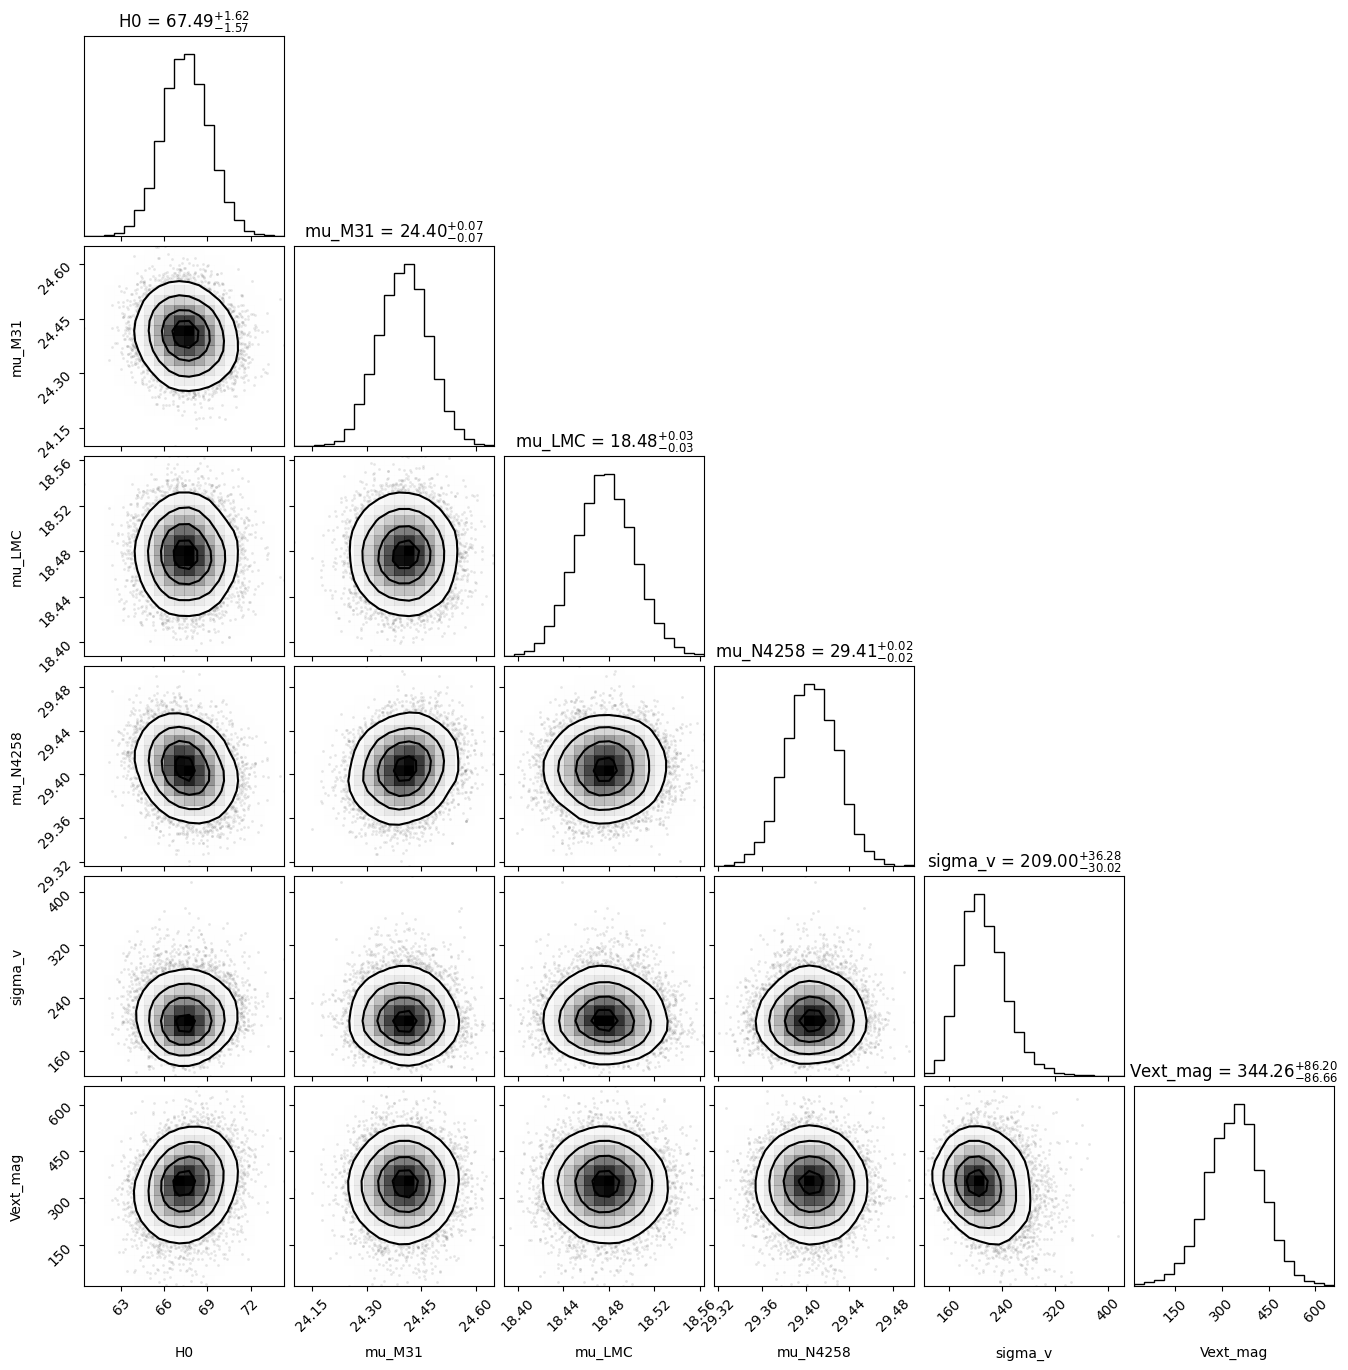

In [6]:
# Extract scalar parameter samples
# params = ["M_W", "Z_W", "b_W"]
# params = ["M_W", "Z_W", "b_W", "dZP",  "H0", "mu_M31", "mu_LMC", "mu_N4258", "sigma_v", "Vext_mag"]
params = ["H0", "mu_M31", "mu_LMC", "mu_N4258", "sigma_v", "Vext_mag",]
param_arrays = [samples[p] for p in params]

nmax = 4

# ks = list(range(nmax)) #+ [37, 38, 39]
ks = []

# Extract mu_host[0] to mu_host[7]
mu_host_subset = [samples["mu_host"][:, i] for i in ks]
# mu_host_subset = [samples["mu_host"][:, i] for i in [38, 39]]

# Concatenate all parameter samples
data_matrix = np.column_stack(param_arrays + mu_host_subset)

# Build label list
labels = params + [f"mu_host[{i}]" for i in ks]
# labels = params + [f"mu_host[{i}]" for i in [38, 39]]

# Generate the corner plot
fig = corner(data_matrix, labels=labels, show_titles=True, smooth=1)
fig.savefig("corner_plot.png", dpi=300)
fig.show()

In [ ]:
from scipy.stats import norm
import posterior_agreement

H0_SH0ES = samples["H0"]
H0_planck = norm(67.4, 0.5).rvs(50000)



chains = (H0_SH0ES, H0_planck)
agreement_1d = posterior_agreement.compute_agreement(chains)

print("p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

In [ ]:
samples["mu_host"].max()

In [28]:
import jax.numpy as jnp
from numpyro import deterministic, factor, plate, sample
from numpyro import infer
import jax
from numpyro.distributions import (Delta, Distribution, MultivariateNormal,
                                   Normal, ProjectedNormal, TruncatedNormal,
                                   Uniform, constraints)

def model():

    speed_of_light = 3e5
    z = sample('z', Uniform(0, 1))
    czpred = z * speed_of_light
    zobs = jnp.asarray([0.1, 0.10001, 0.10007,  ])
    cz_obs = zobs * speed_of_light

    sigma_v = sample('sigma_v', Uniform(0, 25000))

    # ll = - jnp.log(sigma_v)
    with plate('data', len(zobs)):
        sample('cz_obs', Normal(czpred, sigma_v), obs=cz_obs)

num_samples = 10000
num_warmup = 10000

# Using MCMC to sample from the model
rng_key = jax.random.PRNGKey(0)

mcmc = infer.MCMC(infer.NUTS(model), num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key)
mcmc.print_summary()

samples = mcmc.get_samples()

sample: 100%|██████████| 20000/20000 [00:02<00:00, 7727.96it/s, 9 steps of size 6.61e-02. acc. prob=0.42] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   sigma_v     84.85    325.31     23.11      9.12    153.28    704.75      1.00
         z      0.10      0.00      0.10      0.10      0.10    702.23      1.00

Number of divergences: 2056


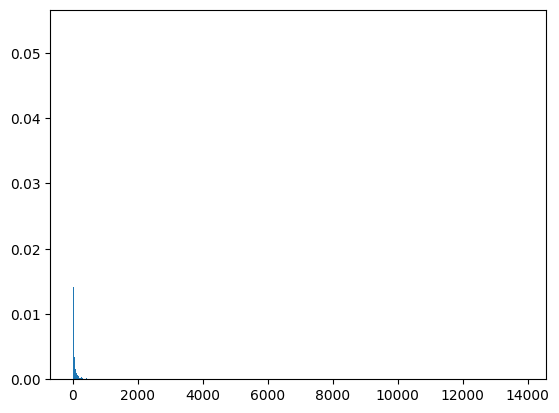

In [29]:
plt.figure()
plt.hist(samples['sigma_v'], bins="auto", density=True)
plt.show()

In [ ]:
H0=(67.4±0.5)km/s

In [ ]:
# Before 2150 are the Cepihed hosts without geometric anchors
# At 2150 Start the N4258 hosts
# At 2593 Start the M31 hosts
# At 2648 start the LMC hosts
# At index 3130 start having supernovae in Cepheid hosts

# Between 3130 and 3207 are the rung two supernovae

# 3207 is the sigma_HST
# 3208 is sigma_Gaia
# 3209 is ? looks like some prior on Z_W
# 3210 is some bullshit that is never used
# 3211 is the sigma_grnd
# 3212 looks like some prior on b_W
# 3213 is the constraint on delta_mu_N4258
# 3214 is the constraint on delta_mu_LMC

# At 3215 and onwards are the Hubble flow supernovae

[3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214]





In [ ]:
data = candel.pvdata.load_SH0ES("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")
Y = np.array(data["Y"], copy=True)
C = np.array(data["C"], copy=True)
L = np.array(data["L"], copy=True).T

# q_names = data["q_names"]

In [ ]:
k = 2647


print(f"Y[{k}] = {Y[k]}")
print(f"C[{k}, {k}] = {C[k, k]}")
print(f"L[{k}, :] = {L[k, :]}")


q_names[L[k, :] != 0.0]